The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews.

The goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
# import the necessary libraries
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
# set specific plot formats
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

# set the default style
plt.style.use('seaborn-v0_8')

In [3]:
# use progress_apply
tqdm.pandas()

## Load Data

In [4]:
# load the .tsv file into a dataframe
df_reviews = pd.read_csv('/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}) # commenting out my local file location

In [5]:
# preview the data
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Let's check the number of movies and reviews over years.

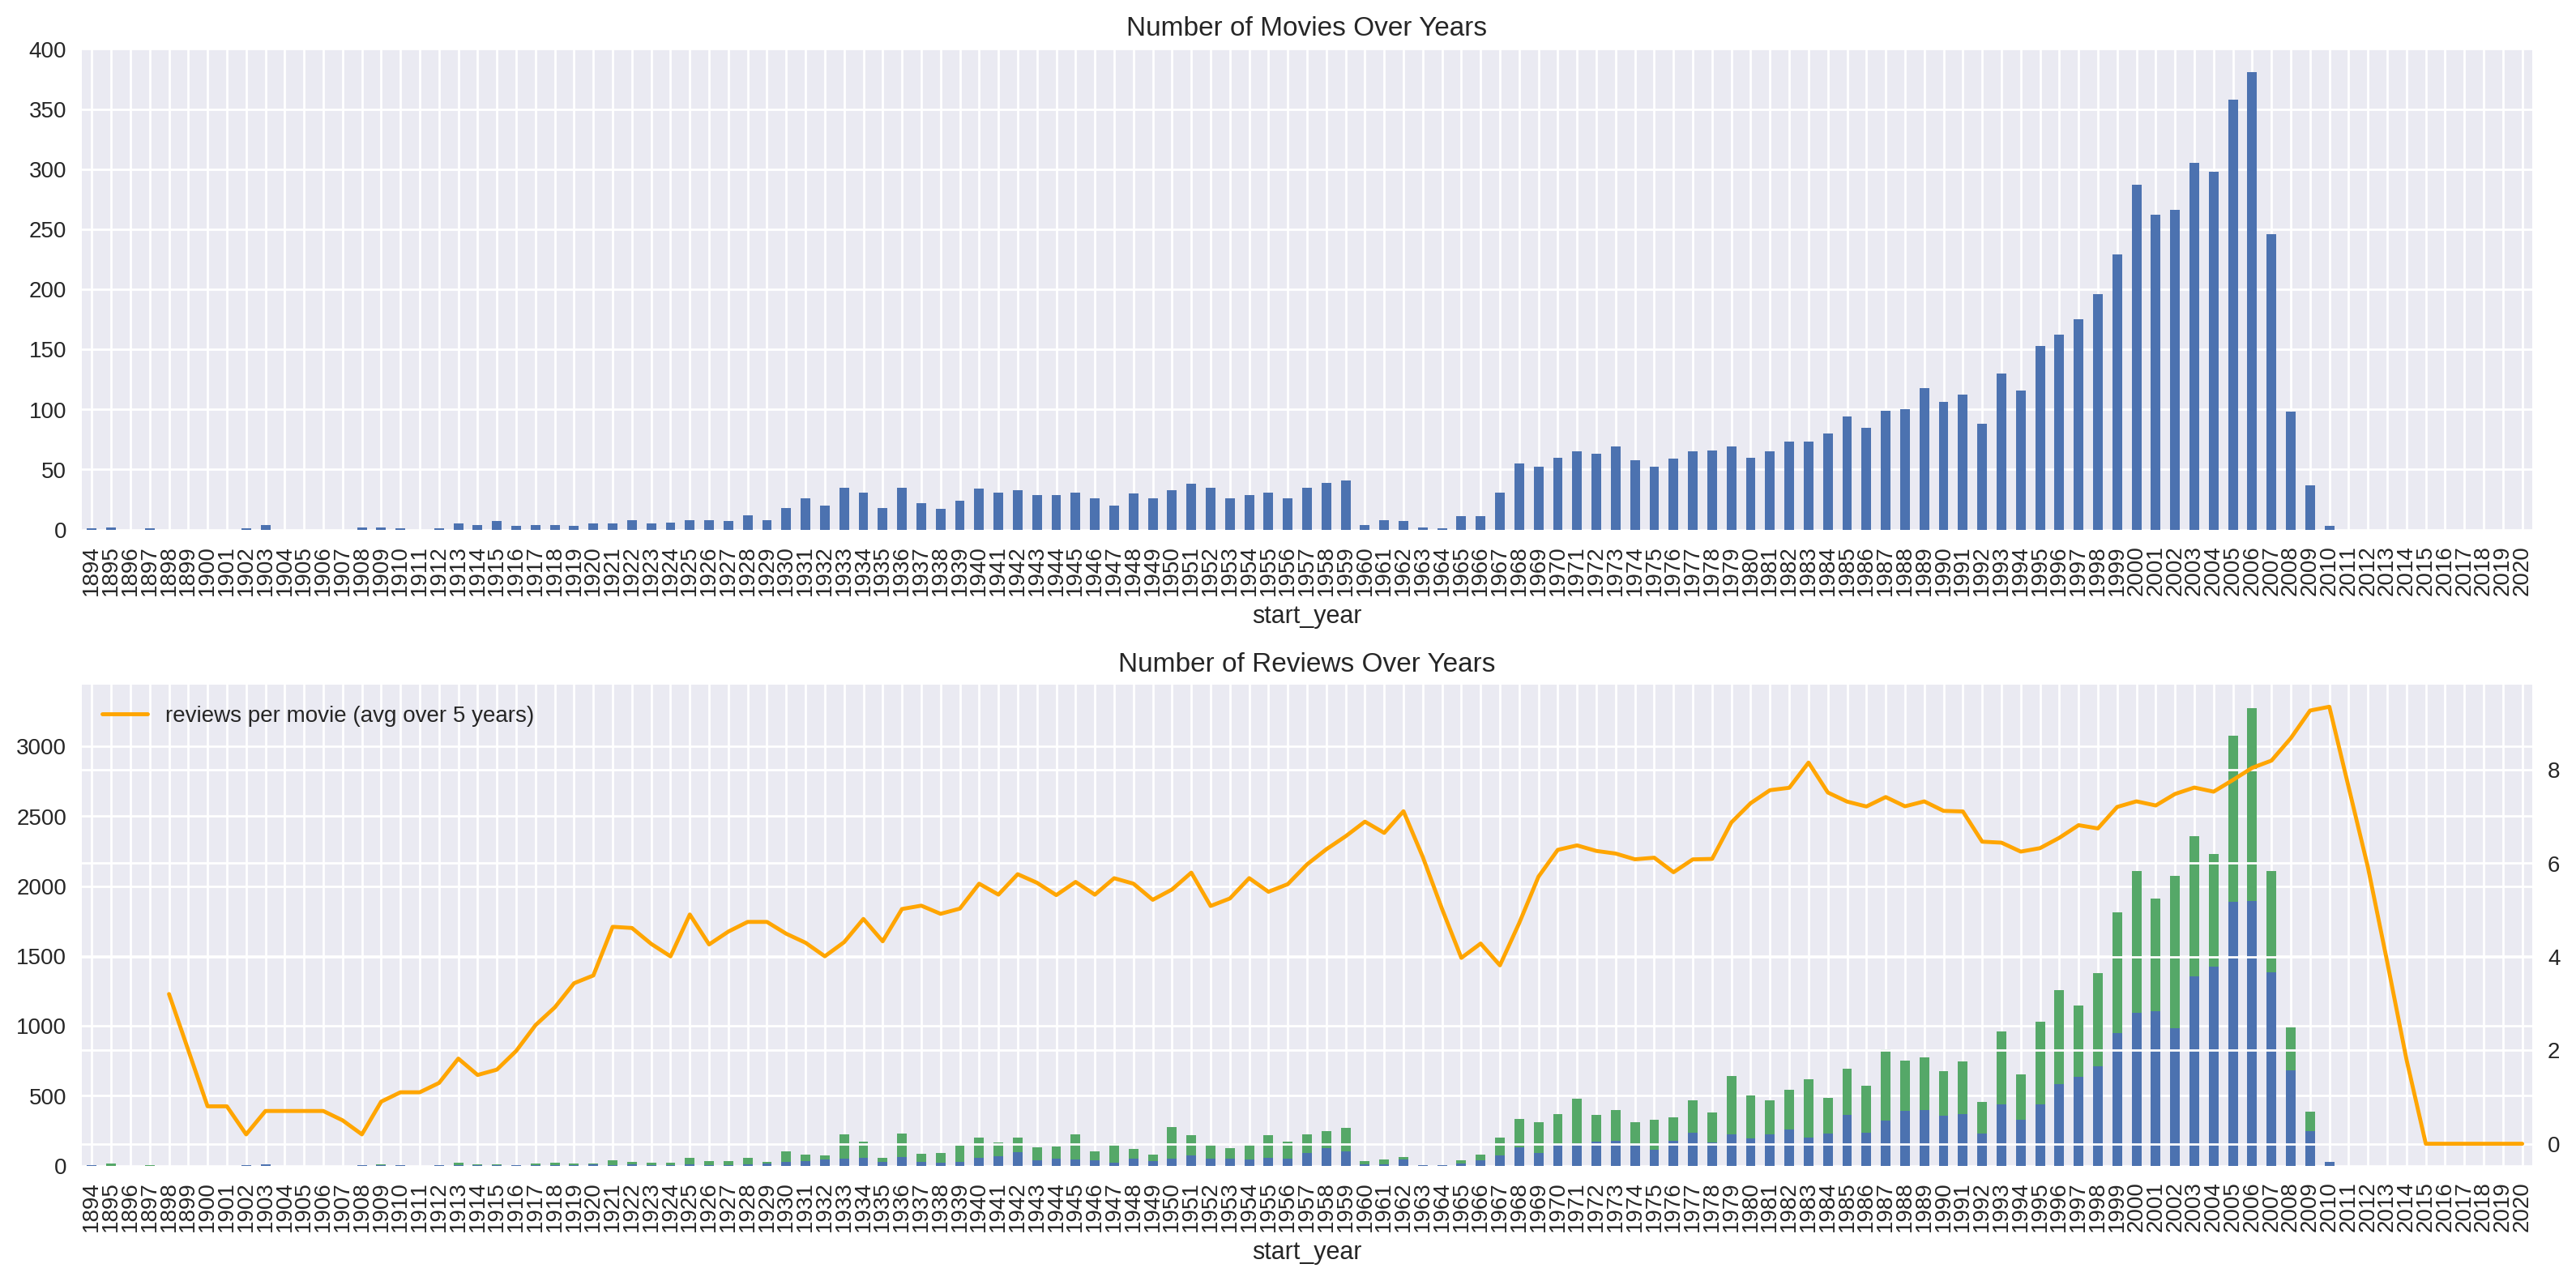

In [6]:
# get the figure and axis objects for the plot
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# set the first axis
ax = axs[0]

# get the number of movies per year, sort the years, and then plot the data
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

# set the second axis
ax = axs[1]

# get the number of reviews per year and reindex the data to include all years from the first movie to 2021
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# plot the data by stacking the positive and negative reviews
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)


# get the rolling average of the number of reviews per movie over 5 years and plot the data
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# set the labels and legend
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

# set the title
ax.set_title('Number of Reviews Over Years')

# set the layout of the plot and display it
fig.tight_layout()

The number of movies over the years has been slowly increasing with a dip between 1960 and 1967. Then, there was a sharp uptick in the 1990's cumulating with a peak in 2006. There is a sharp decline after that--perhaps the data set is incomplete after 2006 or the data is not available.

The rolling avg. number of reviews per movie over 5 years follows a similar pattern as the volume of movies, yet has a less clear upward trend overall. Notably, the number of negative reviews started to rise disproportionately to positive reviews around the year 2000. Perhaps, given the rising popularity of movies, there is a higher likelihood for everyday movie watchers to write reviews and play critic.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

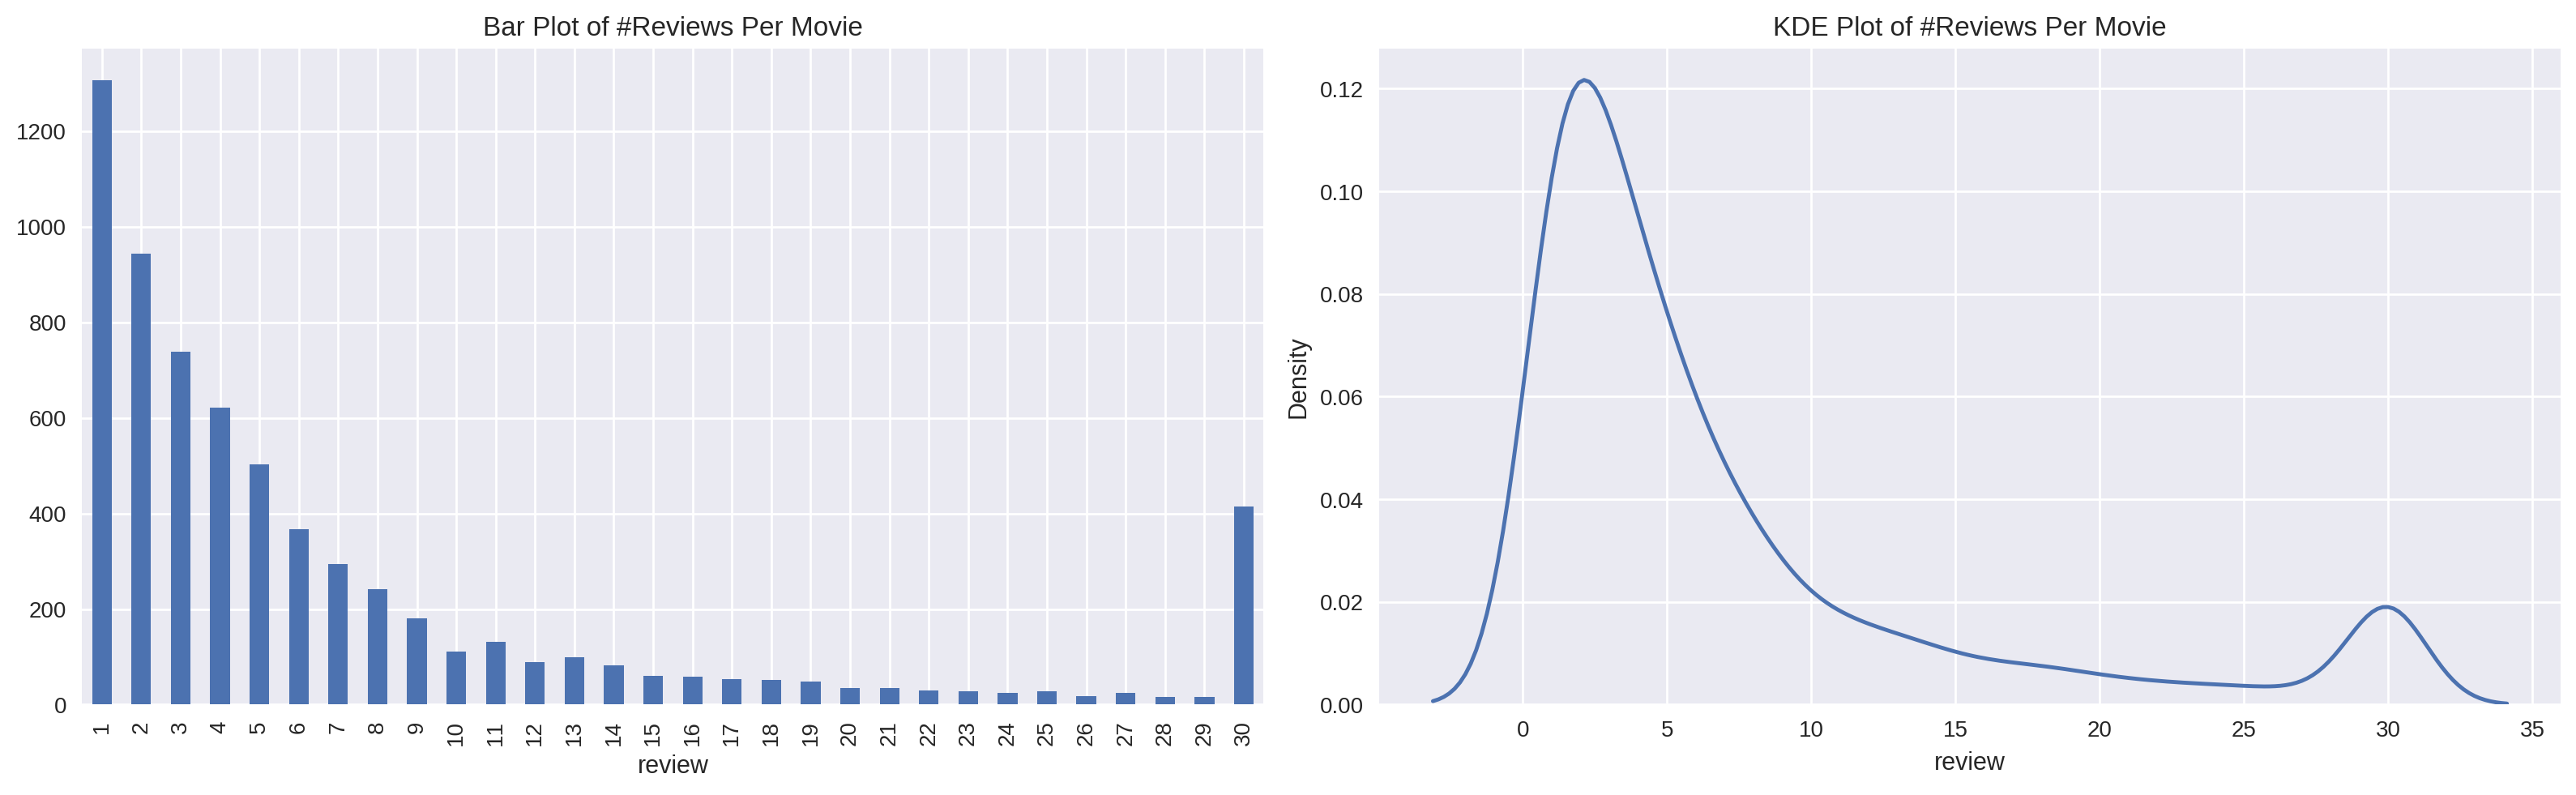

In [7]:
# get the figure and axis objects for the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# set the first axis and plot a bar plot of reviws per movie
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

# set the second axis and plot a KDE plot of reviews per movie
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

# set the layout of the plot and display it
fig.tight_layout()

Most movies have 1-10 reviews, but there is an outlier spike at 30 reviews per movie as well--perhaps these represent movies that people feel passionate about.

In [8]:
df_reviews['pos'].value_counts()

,count
pos,
0,23715
1,23616


The classes are quite balanced.

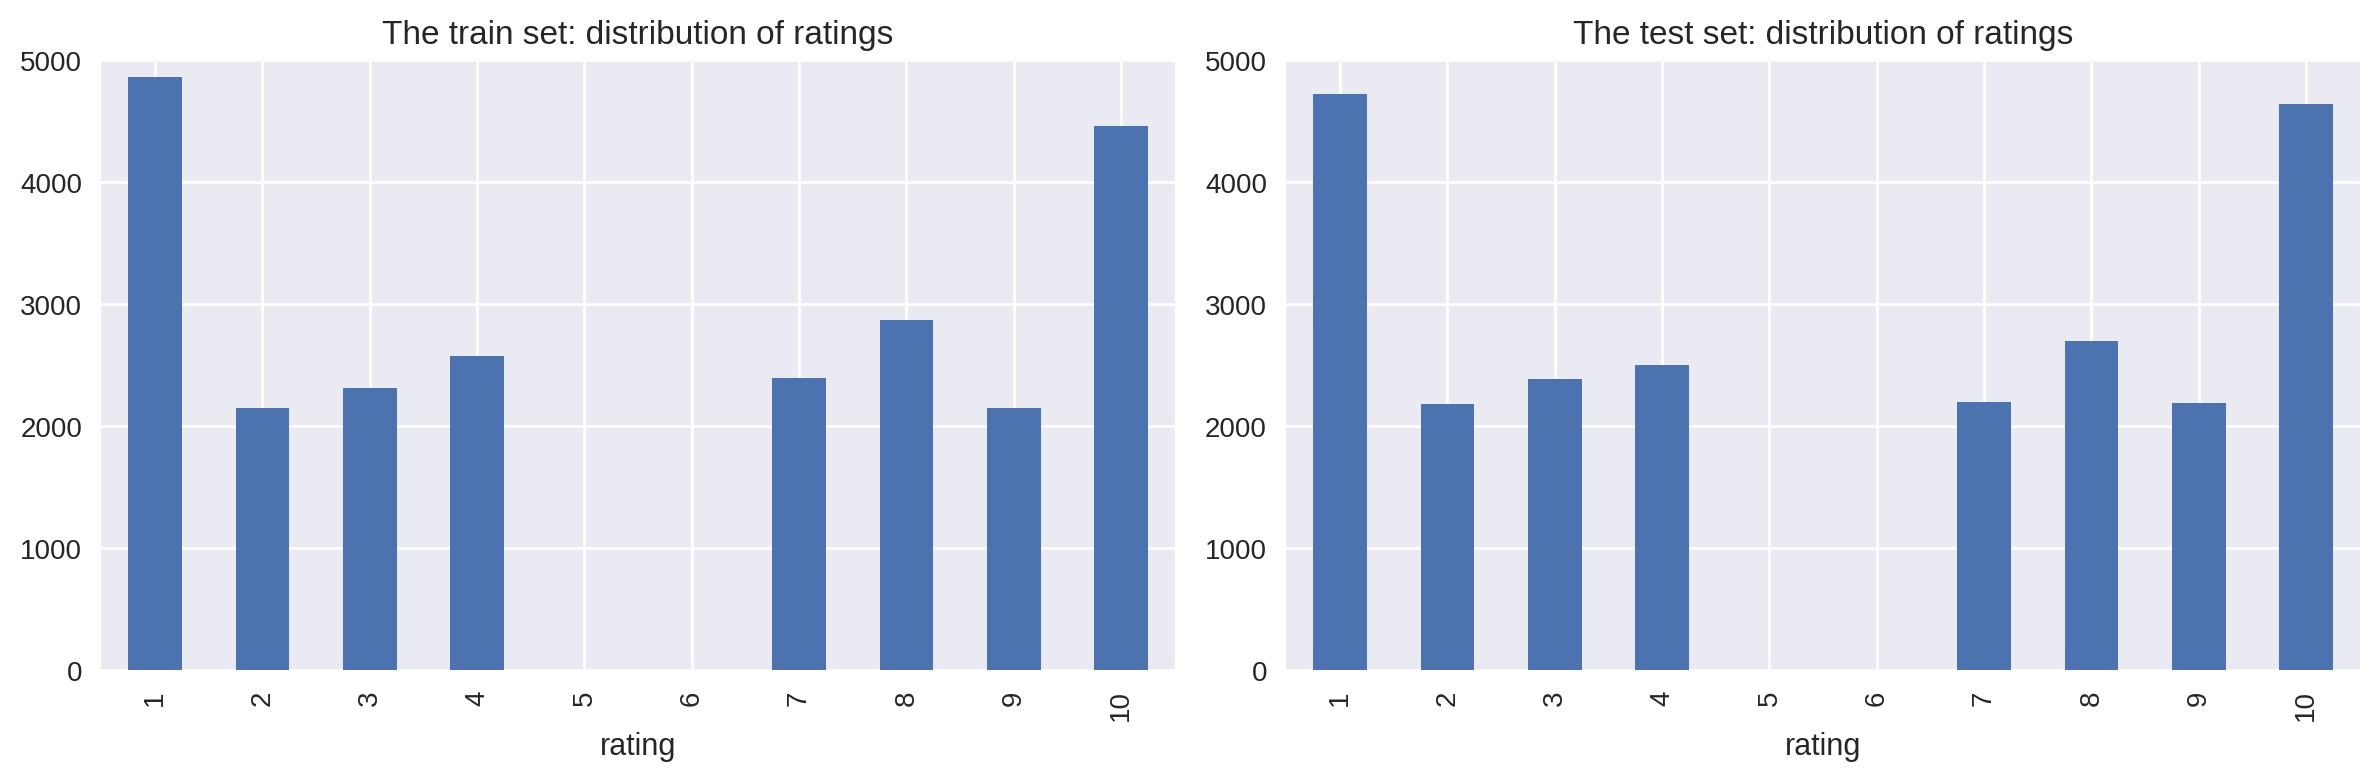

In [9]:
# get the figure and axis objects for the plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# set the first axis and plot a bar chart of the distributions of ratings for the training set
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

# set the second axis and plot a bar chart of the distributions of ratings for the testing set
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

# set the layout of the plot and display it
fig.tight_layout()

Distribution of negative and positive reviews over the years for training and testing sets follow a very similar distribution.

<ipython-input-10-8b9c85a96de2>:19: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-10-8b9c85a96de2>:20: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-10-8b9c85a96de2>:39: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-10-8b9c85a96de2>:40: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

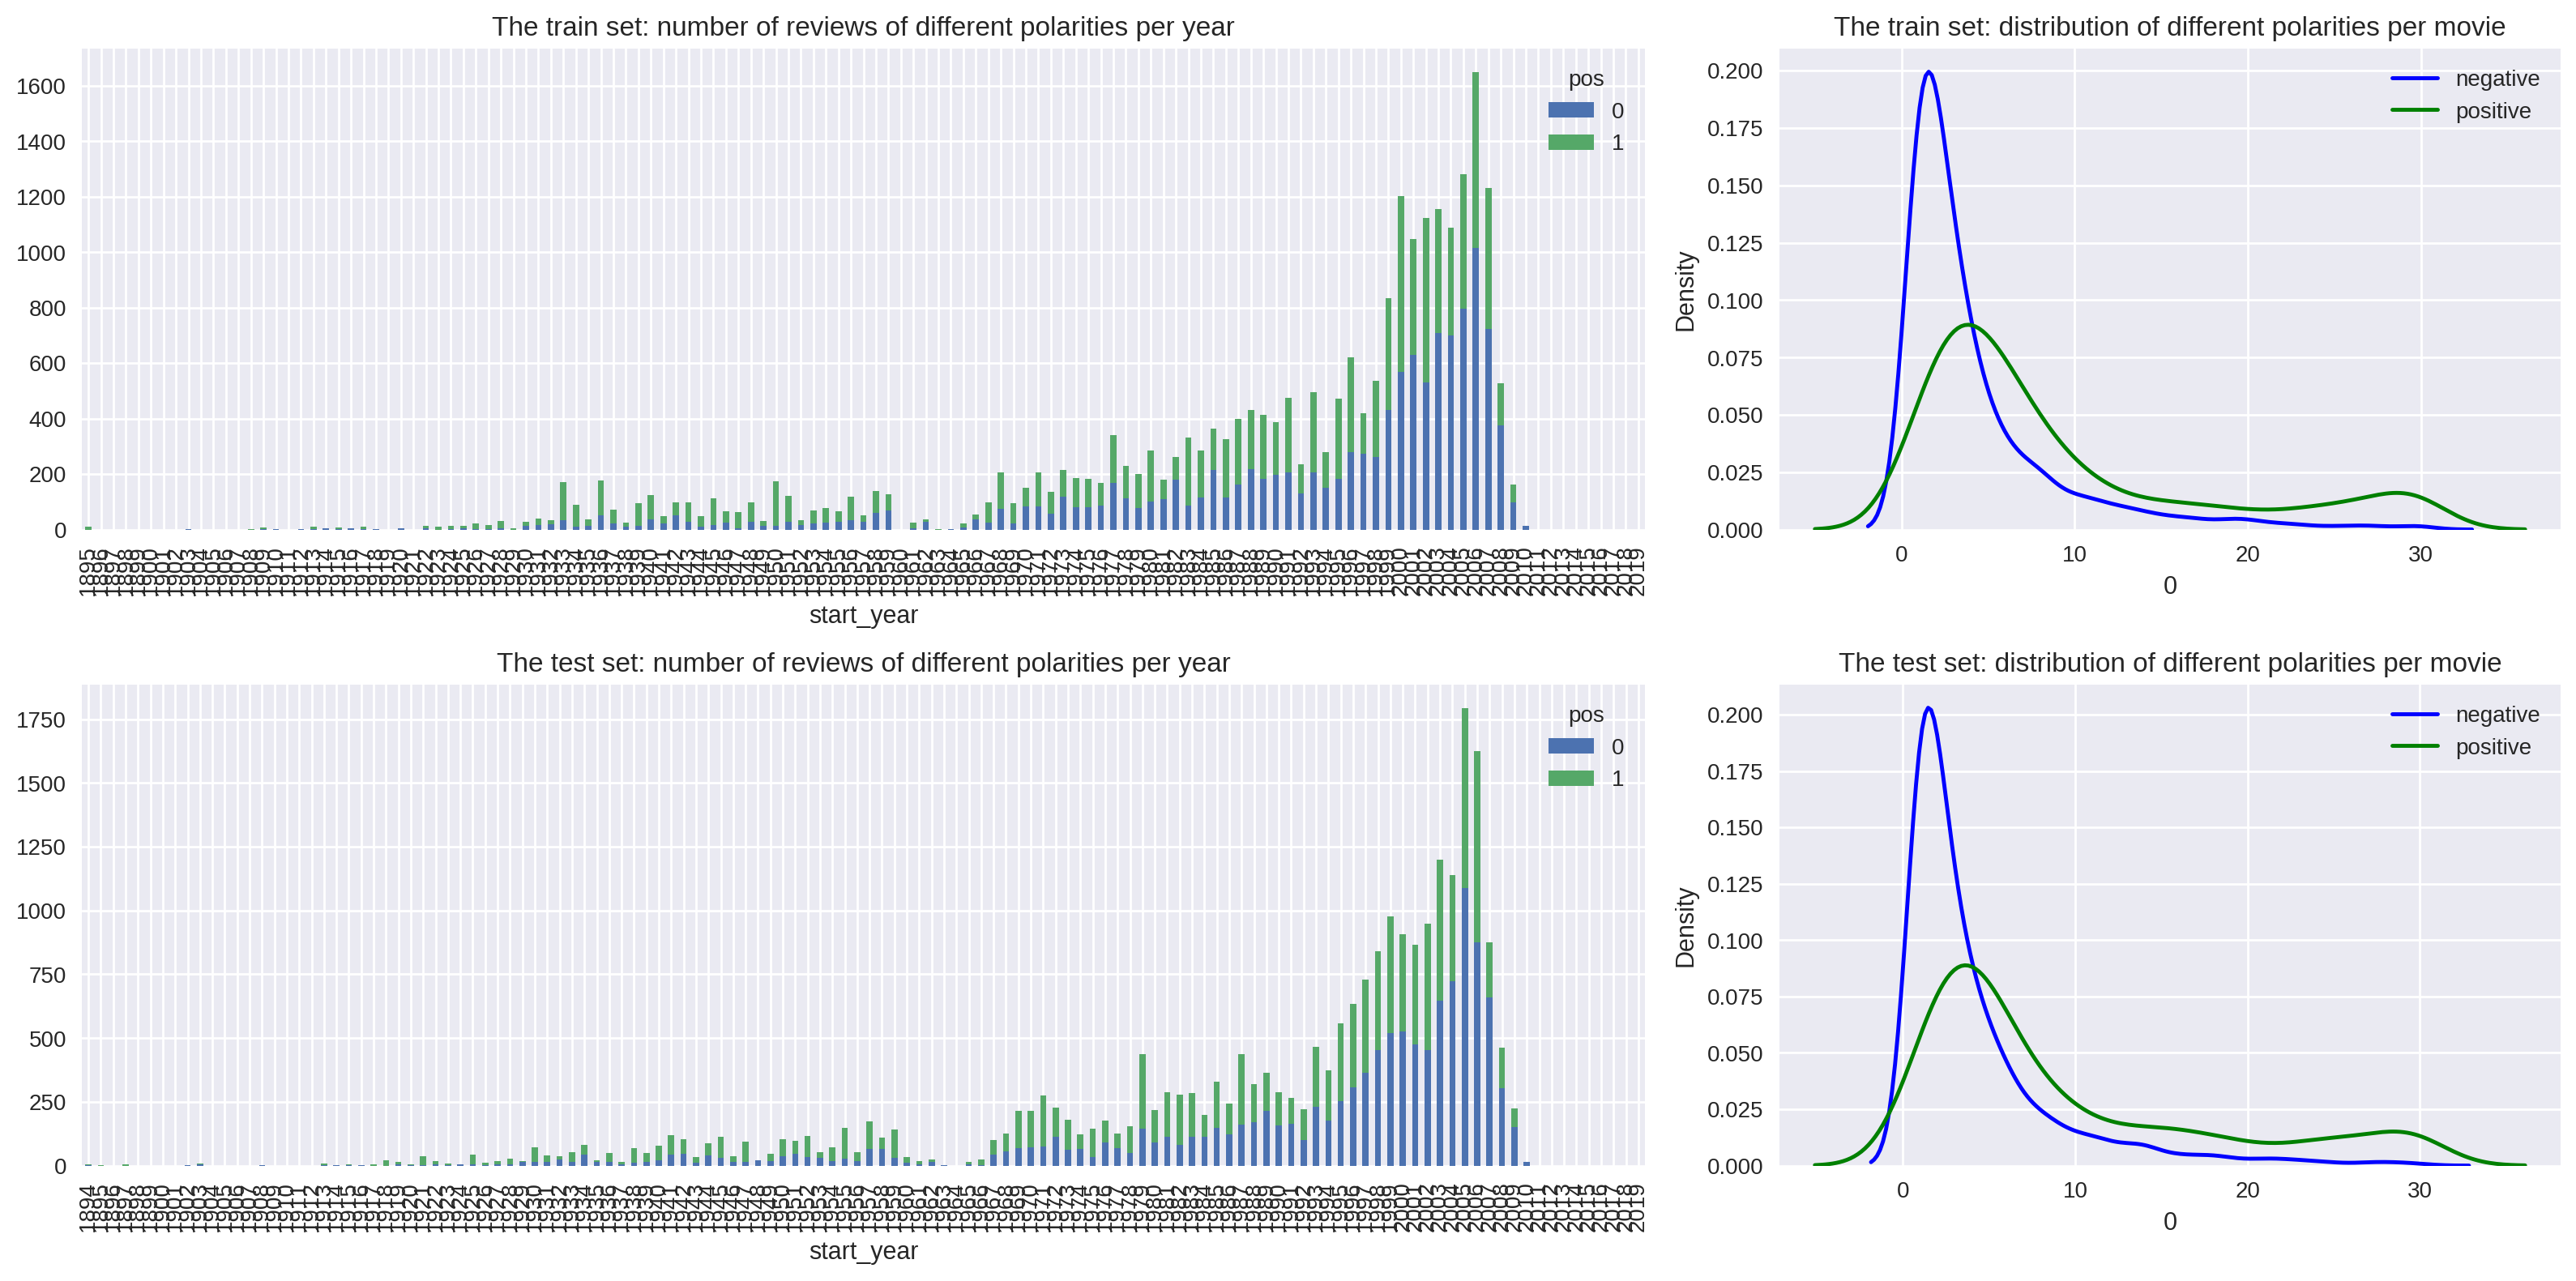

In [10]:
# get the figure and axis objects for the plot
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# set the first axis for the train set
ax = axs[0][0]

# get the number of reviews of different polarities per year, reindex the data to include all years from the first movie to 2020, and plot a bar chart
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

# set the second axis for the train set
ax = axs[0][1]

# get the distribution of different polarities per movie and plot the data via a KDE plot
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

# set the first axis for the test set
ax = axs[1][0]

# get the number of reviews of different polarities per year, reindex the data to include all years from the first movie to 2020, and plot a bar chart
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

# set the second axis for the test set
ax = axs[1][1]

# get the distribution of different polarities per movie and plot the data via a KDE plot
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

# set the layout of the plot and display it
fig.tight_layout()

While there are slight differences in the polarity of reviews by year in the train and test sets, they are overall very similar--especially when assessed through a per movie distribution.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project.

In [11]:
import sklearn.metrics as metrics

# define a function to evaluate the performance of a model based on training and testing data
def evaluate_model(model, train_features, train_target, test_features, test_target):

    # dictionary to store evaluation metrics for both training and test datasets
    eval_stats = {}

    # create a figure with 3 subplots to visualize F1 Score, ROC curve, and Precision-Recall Curve
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # iterate over both training and test datasets for evaluation
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        # initialize evaluation stats for each dataset (train/test)
        eval_stats[type] = {}

        # make predictions using the model
        pred_target = model.predict(features)  # class predictions (binary)
        pred_proba = model.predict_proba(features)[:, 1]  # predicted probabilities for the positive class

        # F1 Score evaluation across multiple thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)  # Thresholds ranging from 0 to 1 (in steps of 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # calculate ROC curve and AUC (Area Under Curve)
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc  # Store ROC AUC score

        # calculate Precision-Recall curve and Average Precision Score (APS)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps  # Store APS score

        # fefine colors for plotting based on whether it's training or test data
        color = 'blue' if type == 'train' else 'green'

        # plot F1 score against different thresholds
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)  # Find the index of the maximum F1 score
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')

        # mark specific thresholds with 'X' markers on the F1 score plot
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))  # Find the closest threshold value
            marker_color = 'orange' if threshold != 0.5 else 'red'  # Special color for threshold 0.5 (default)
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)

        # set plot limits, labels, and title for F1 score plot
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score')

        # plot ROC curve (True Positive Rate vs False Positive Rate)
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')

        # mark specific thresholds on the ROC curve with 'X' markers
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)

        # plot diagonal line for reference (representing random performance)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # plot Precision-Recall curve (Precision vs Recall)
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')

        # mark specific thresholds on the Precision-Recall curve with 'X' markers
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)

        # set plot limits, labels, and title for Precision-Recall curve
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        # calculate additional evaluation metrics: Accuracy and F1 score using default 0.5 threshold
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    # convert the evaluation statistics dictionary to a DataFrame for easy viewing
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)  # Round the values to 2 decimal places for better readability
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))  # Reorder the rows

    # print the DataFrame showing the evaluation statistics for both training and test datasets
    print(df_eval_stats)

    return


## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
# function to normalize text
def normalize_text(text):
    # convert to lowercase
    text = text.lower()

    # remove digits, punctuation, and special characters using re.sub
    text = re.sub(r'[^a-z\s]', '', text)

    return text

# apply the function to the 'review' column and create a new column 'review_norm'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
# make a copy of the df_reviews dataset and store them in separate dataframes for the training and testing sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# store the labels for the training and testing sets in y_train and y_test respectively
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

# print the shape of df_reviews_train and df_reviews_test
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [14]:
# import the DummyClassifier
from sklearn.dummy import DummyClassifier

In [15]:
# train the model on a constant prediction of class 0
model0 = DummyClassifier(strategy="constant", constant=0)
model0.fit(df_reviews_train['review_norm'], y_train)

DummyClassifier(constant=0, strategy='constant')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


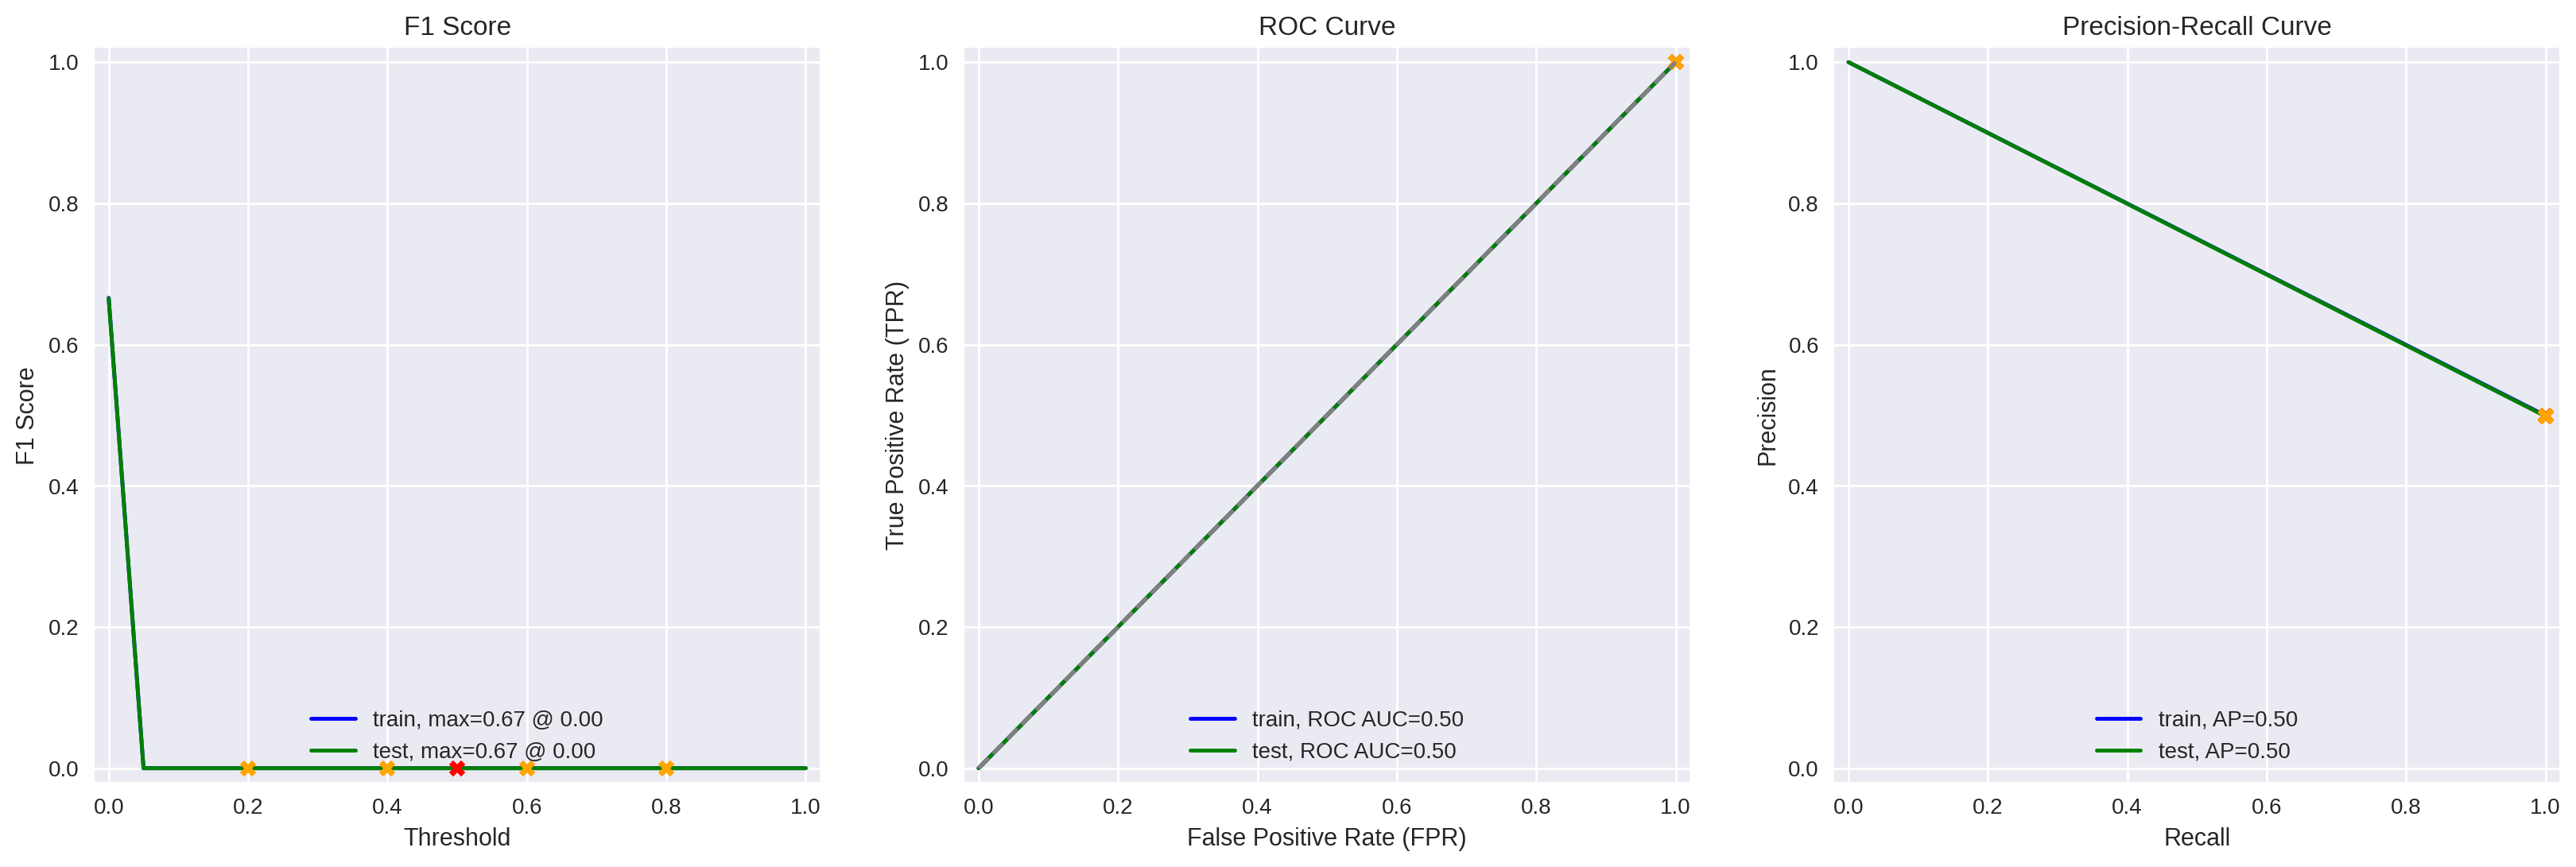

In [16]:
# evaluate the DummyClassifer model
evaluate_model(model0, df_reviews_train['review_norm'], y_train, df_reviews_test['review_norm'], y_test)

As expected, the accuracy score of the dummy model is 0.5. The F1 score is zero so we have lots of room for improvement.

### Model 1 - NLTK, TF-IDF and LR


In [17]:
# import the necessary libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()


# function to tokenize and lemmatize the normalized text
def lemmatize_text(text):
    # tokenize the text by splitting
    tokens = text.split()

    # lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # join tokens back into a lemmatized string (optional, for further processing)
    lemmatized_text = " ".join(lemmatized_tokens)

    return lemmatized_text

# apply the lemmatization function to the normalized text for the train and test sets
df_reviews_train['lemmatized_reviews'] = df_reviews_train['review_norm'].apply(lemmatize_text)
df_reviews_test['lemmatized_reviews'] = df_reviews_test['review_norm'].apply(lemmatize_text)


In [19]:
# specify the stop words (convert to list)
stop_words = list(stopwords.words('english'))

# initialize the vectorizer
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

# fit the vectorizer on the lemmatized reviews
X_train_1 = count_tf_idf.fit_transform(df_reviews_train['lemmatized_reviews'])

# transform the test set
X_test_1 = count_tf_idf.transform(df_reviews_test['lemmatized_reviews'])

# initialize the logistic regression model
model_1 = LogisticRegression(random_state=12345)

# fit the model on the train set
model_1.fit(X_train_1, y_train)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


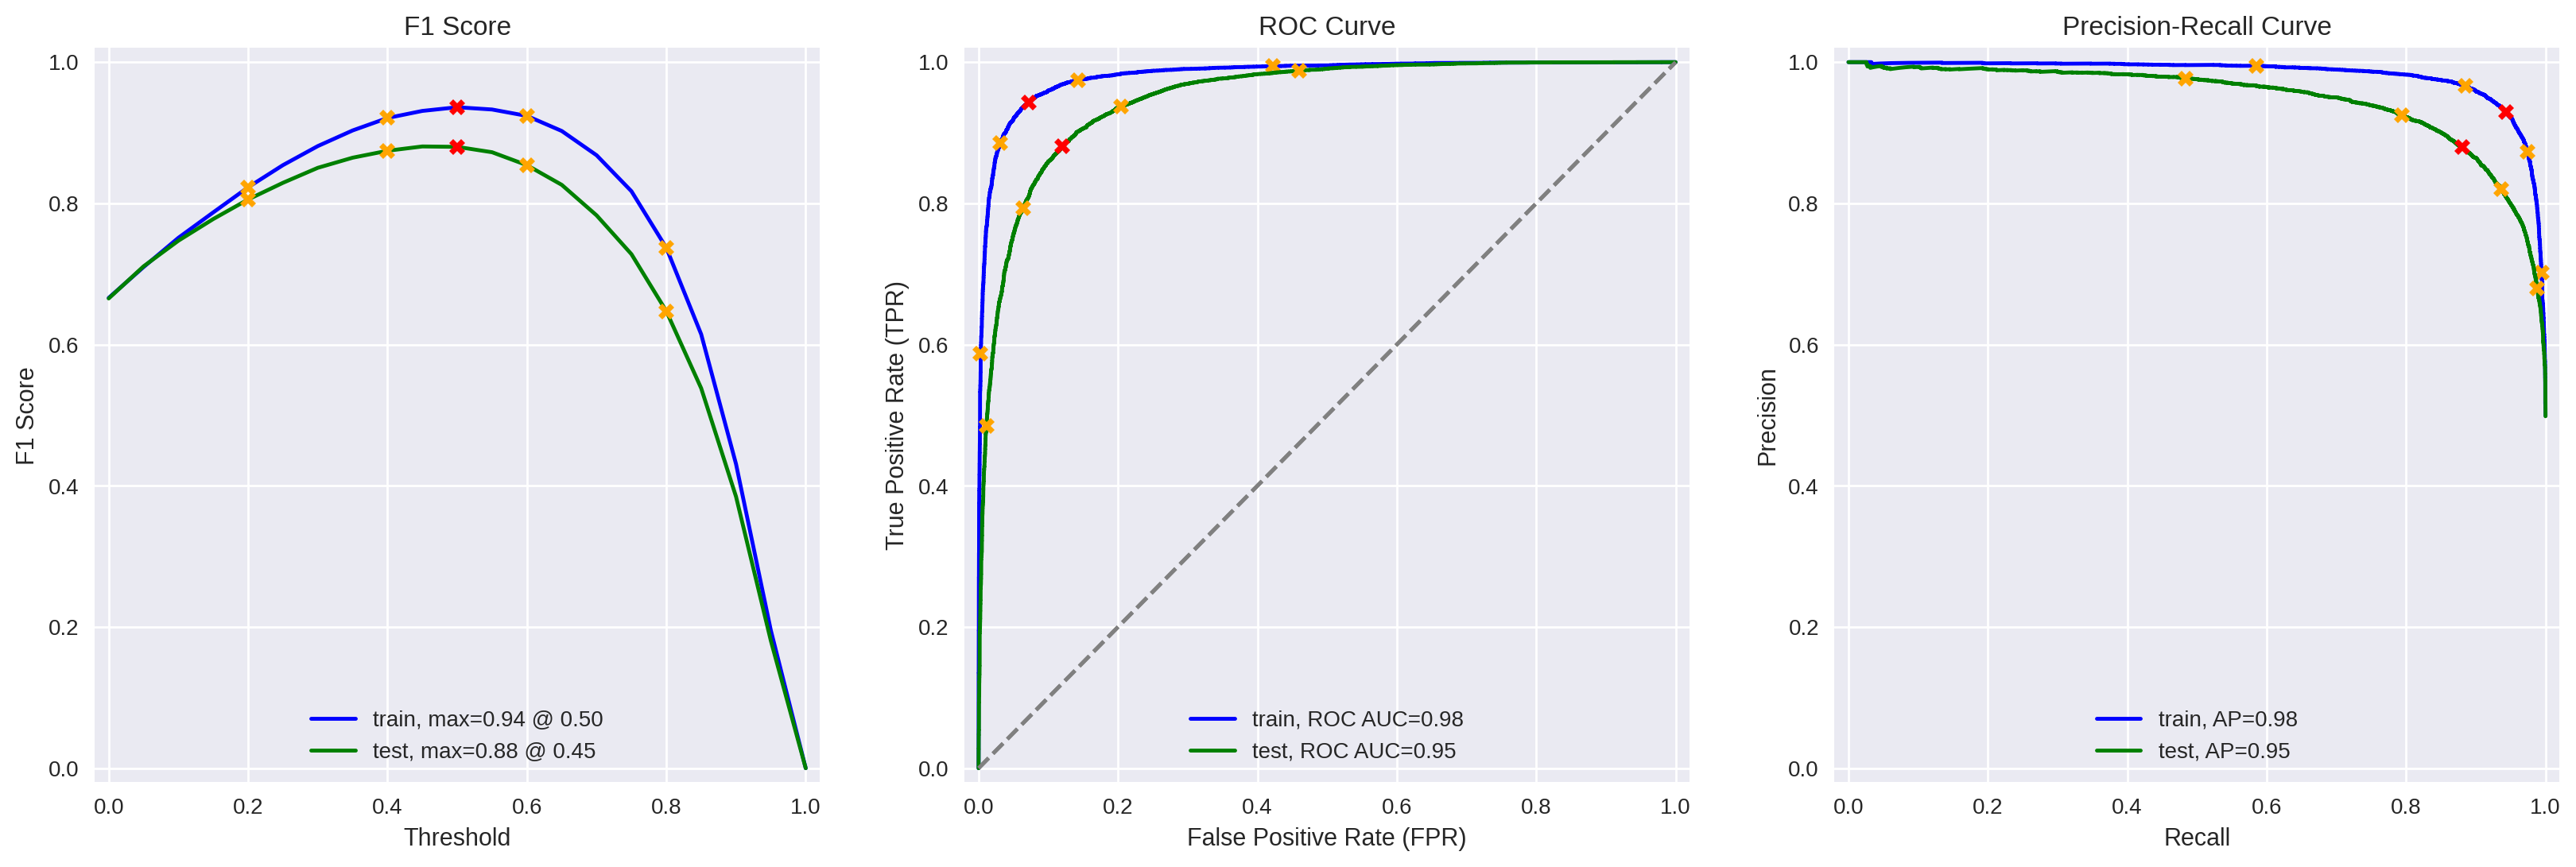

In [20]:
# evaluate the NLTK, TF-IDF and LR model
evaluate_model(model_1, X_train_1, y_train, X_test_1, y_test)

Great news--model 1 (using nltk, TF-IDF, and logistic regression) has beat the threshold F1 score of 0.85 for our project. Let's see if we can make it even better.

### Model 2 - spaCy, TF-IDF and LR

In [21]:
# import necessary libraries and download resources
import spacy
spacy.cli.download("en_core_web_sm")


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
# define a function to preprocess test with spacy
def text_preprocessing_2(text):

    # lemmatize each token in doc and join the tokens together
    doc = nlp(text)
    # tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [23]:
# lemmatize the normalized reviews using spacy by applying the text_preprocessing_2 dunction to the 'review' norm column for training and testing sets
df_reviews_train['spacy_lemmatized_reviews'] = df_reviews_train['review_norm'].apply(text_preprocessing_2)
df_reviews_test['spacy_lemmatized_reviews'] = df_reviews_test['review_norm'].apply(text_preprocessing_2)

In [24]:
# fit the vectorizer on the lemmatized reviews
X_train_2 = count_tf_idf.fit_transform(df_reviews_train['spacy_lemmatized_reviews'])

# transform the test set
X_test_2 = count_tf_idf.transform(df_reviews_test['spacy_lemmatized_reviews'])

# initialize the logistic regression model
model_2 = LogisticRegression(random_state=12345)

# fit the model on the train set
model_2.fit(X_train_2, y_train)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


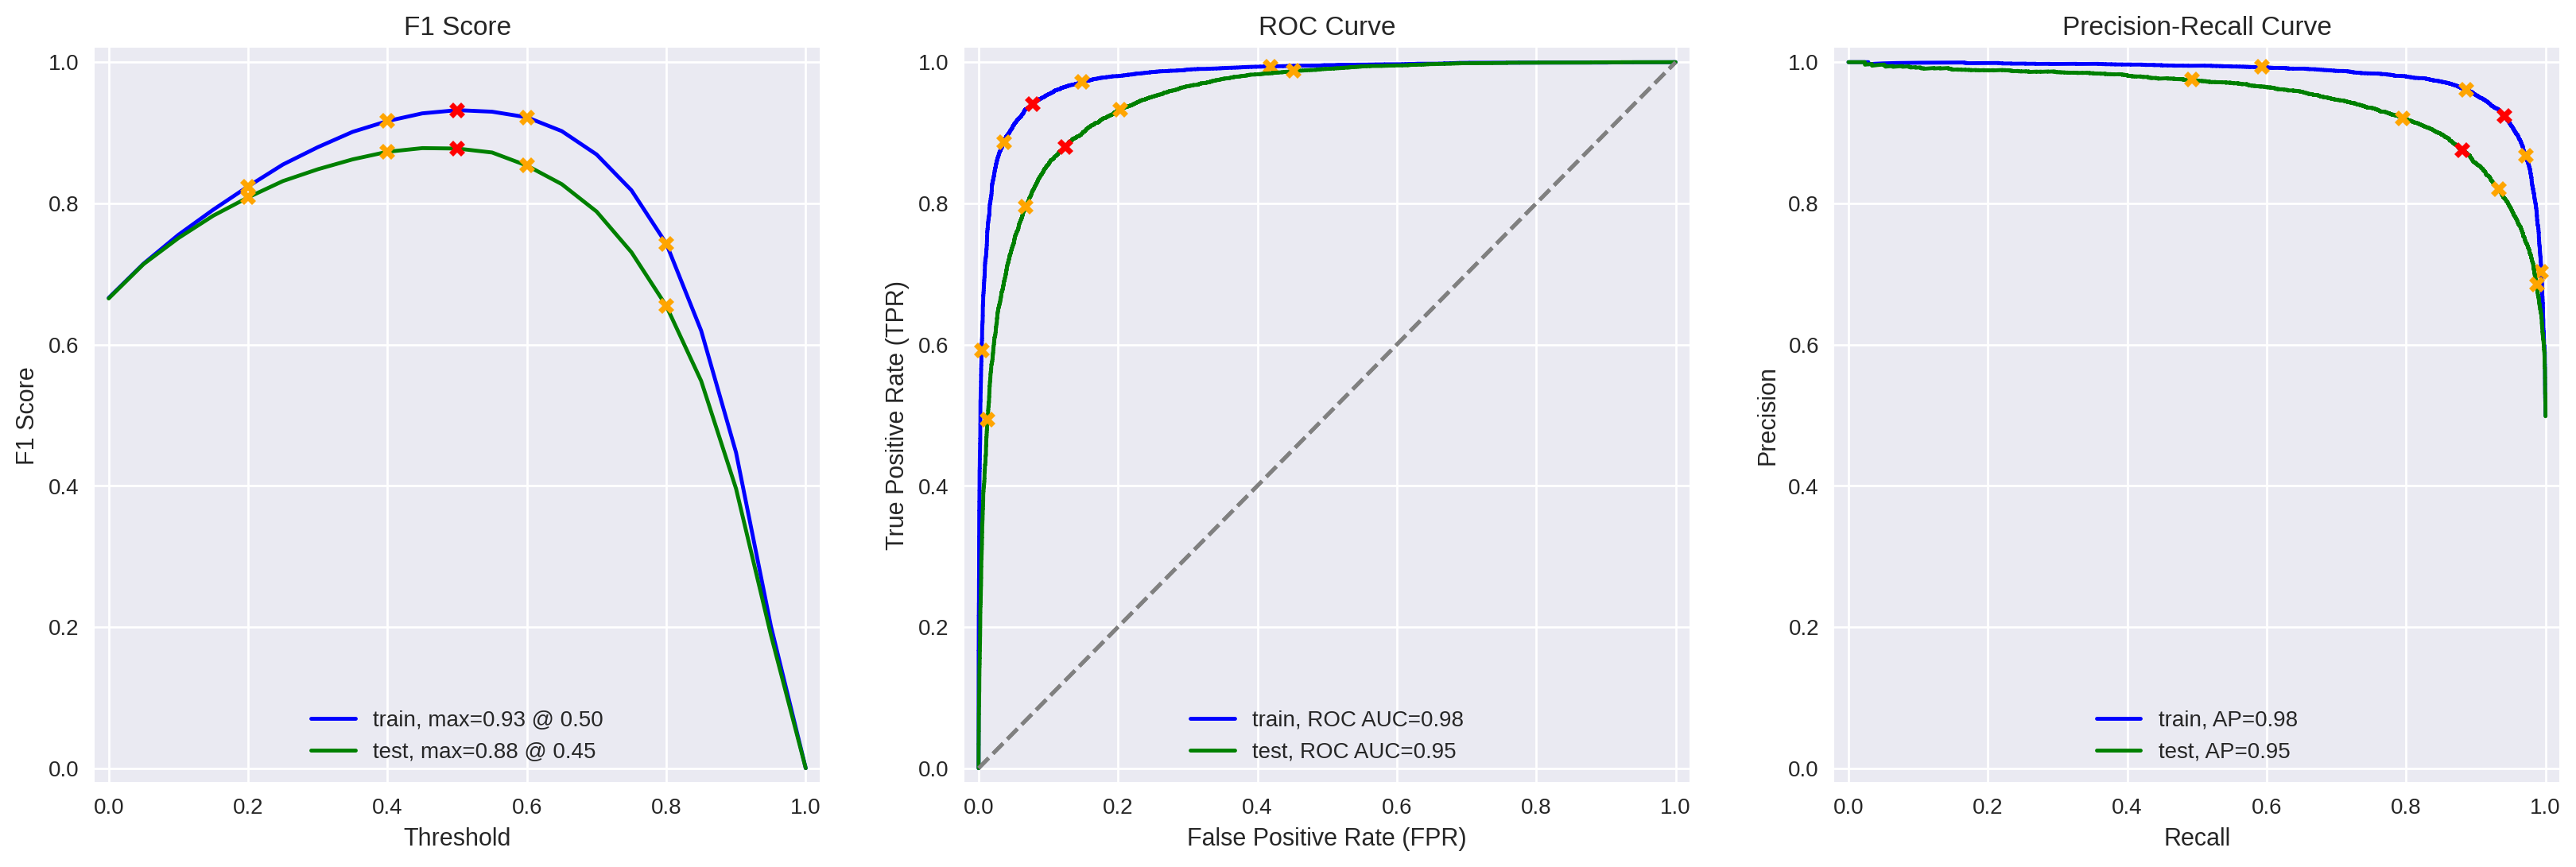

In [25]:
# evalulate the spaCy, TF-IDF and LR model
evaluate_model(model_2, X_train_2, y_train, X_test_2, y_test)

The F1 score for our second model (using spacy, TF-IDF, and LGBMClassifier) is the same as our first model (0.88). Next, we'll see if a LGBM Classifer model can give us a better score than Logistic Regression.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [26]:
# import necessary libraries
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [27]:
model_3 = LGBMClassifier()

# define the parameter grid
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [100, 500],
    'num_leaves': [31],
    'max_depth': [10, 30]
}

# perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=model_3, param_distributions=param_grid, n_iter=10, cv=2, verbose=1, random_state=12345, n_jobs=-1)

# fit the random search model
random_search.fit(X_train_2, y_train)

# Get the best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.806316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445946
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Best Hyperparameters: {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.1}


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.663799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 445946
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


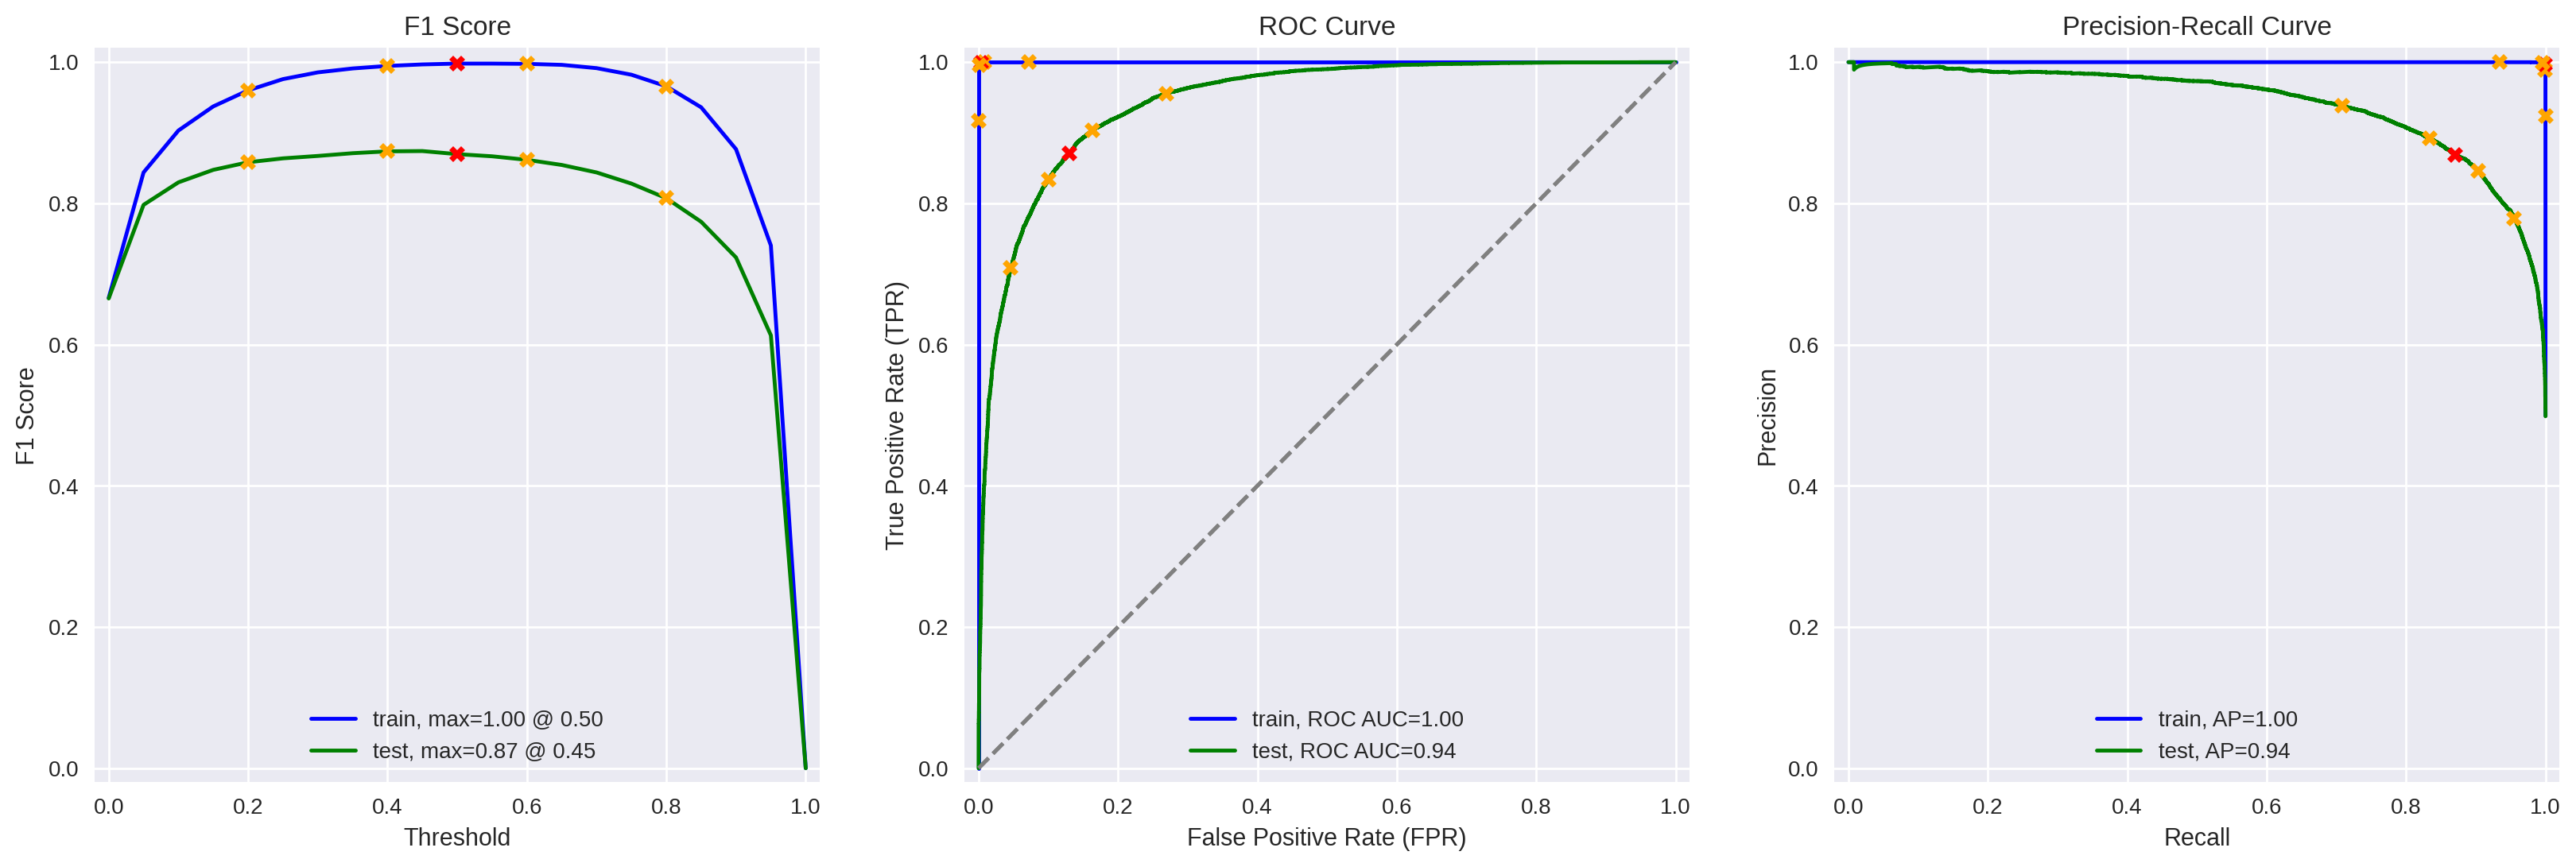

In [28]:
# initialize the LGBM model with the best hyperparameters from the randomized search
best_model_3 = LGBMClassifier(random_state=12345, num_leaves=31, n_estimators=500, max_depth=30, learning_rate=0.1)

# fit the model on the train set
best_model_3.fit(X_train_2, y_train)

# evaluate the model
evaluate_model(best_model_3, X_train_2, y_train, X_test_2, y_test)

With spaCy, TF-IDF and LGBMClassifier, our third model achieved an F1 score of 0.87, which is above our project threshold, but still not as good as our first or second models with Logistic Regression.

Let's try BERT as our final model in this project in an attempt to get a higher F1 score.

###  Model 4 - BERT

In [29]:
# import necessary libraries
import torch
import transformers

In [30]:
# specify the tokenizer, config, and model for BERT from the 'bert-base-uncased' pretrained model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [31]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for input_text in texts:
        ids = tokenizer.encode(
        input_text.lower(),
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,
    )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)

    # <put your code here to create ids_list and attention_mask_list>
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device) # Move attention_mask_batch to the same device as ids_batch


        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [32]:
# get BERT embeddings for the training normalized reviews and save them as the training features
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')


Using the cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

<ipython-input-31-2c20064ce298>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [33]:
# get BERT embeddings for the testing normalized reviews and save them as the training features
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/236 [00:00<?, ?it/s]

In [34]:
# print the shape of the training 'review_norm' column, training features, and training label
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(y_train.shape)

(23796,)
(23796, 768)
(23796,)


df_reviews_train, train_features_9, and y_train all have the same number of rows as expected while train_features_9 has 768 columns.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 500],  # Number of trees in the forest
    'max_depth': [10, 30]  # Maximum depth of the tree
}

# Define the scoring metric (F1 score in this case)
scorer = make_scorer(f1_score)

# Perform the randomized search with cross-validation
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter settings sampled (you can increase or decrease this)
    cv=3,  # 3-fold cross-validation
    scoring=scorer,
    verbose=1,
    random_state=42,
    n_jobs=-1  # use all processors
)

# Fit the random search on training data (BERT embeddings or any feature set)
random_search.fit(train_features_9, y_train)

# Output the best parameters and the best F1 score
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'n_estimators': 500, 'max_depth': 30}
Best F1 score:  0.8048679103149228


          train  test
Accuracy    1.0  0.81
F1          1.0  0.81
APS         1.0  0.89
ROC AUC     1.0  0.89


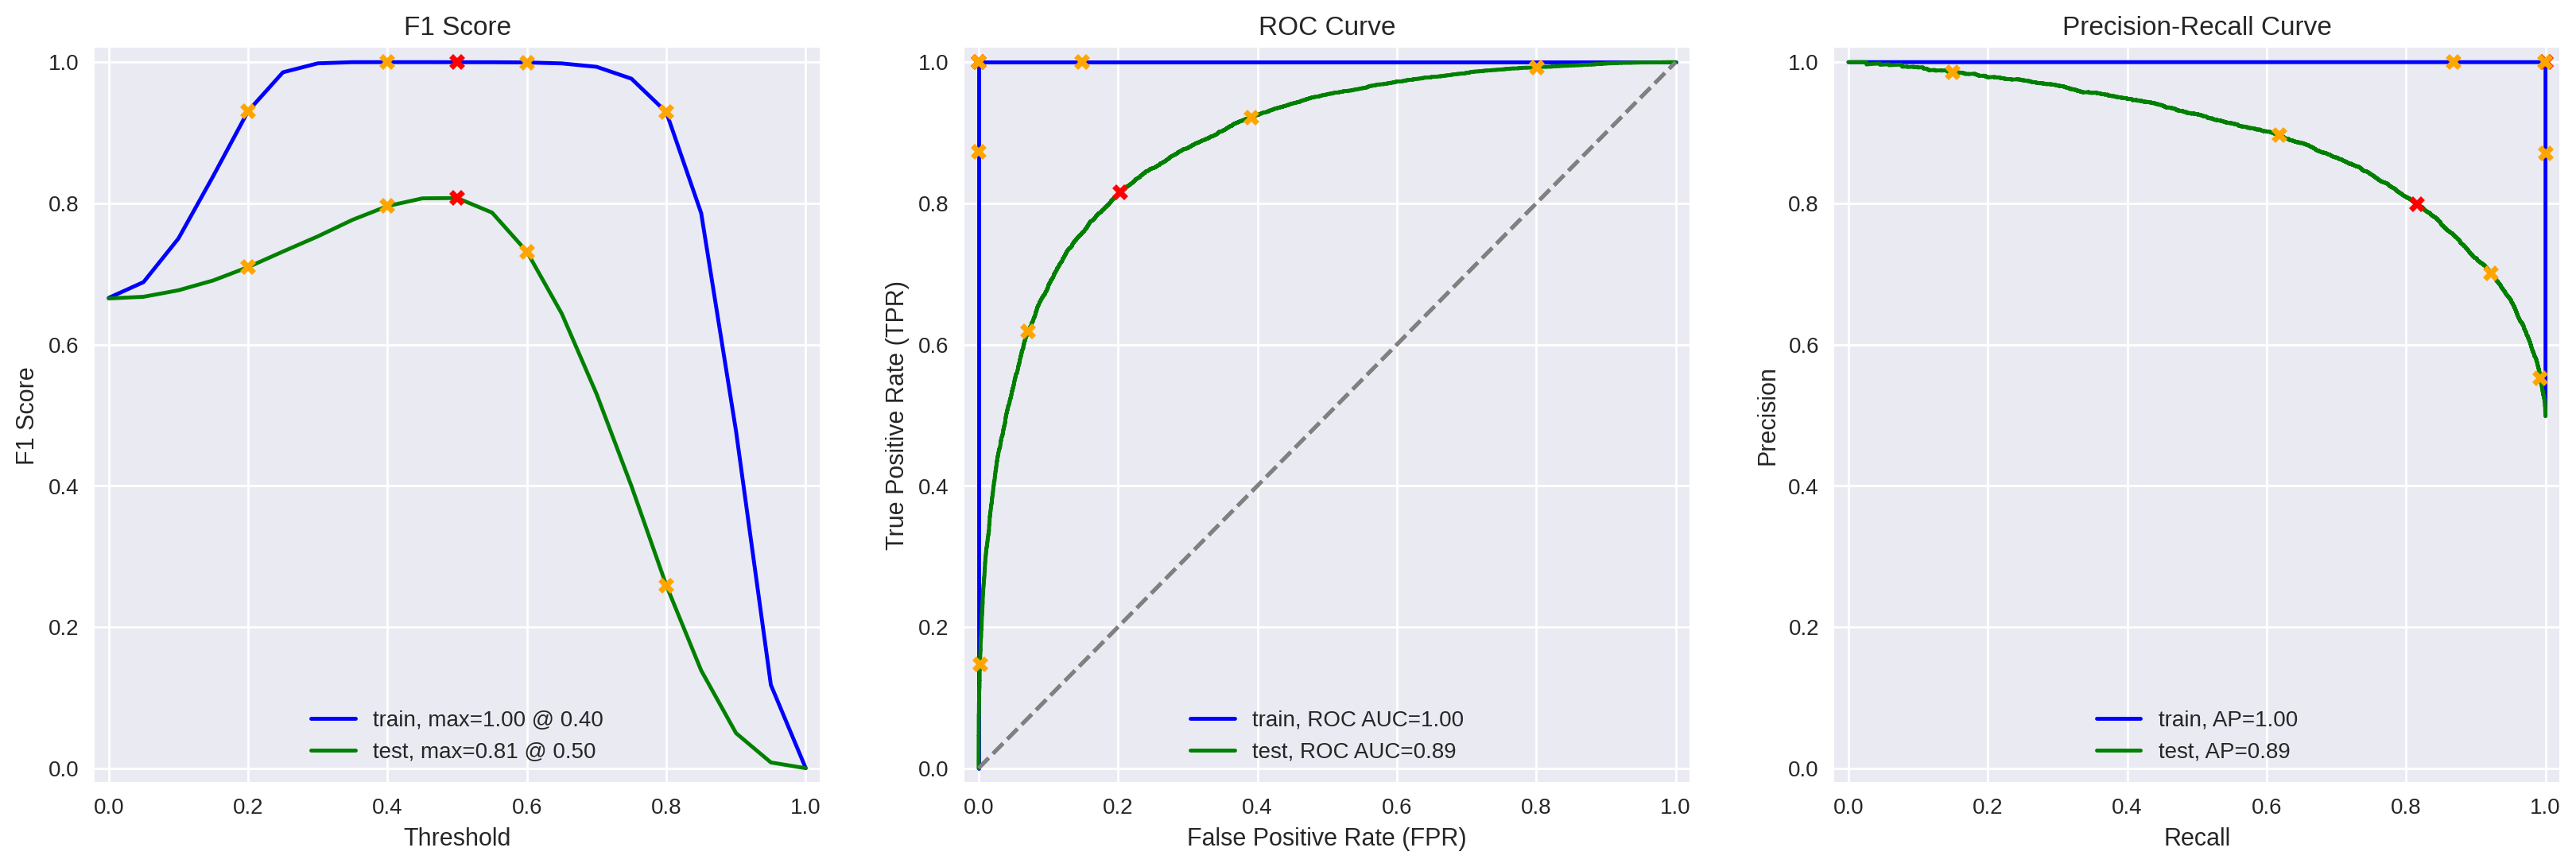

In [36]:
# Get the best model
model_4 = random_search.best_estimator_

# Evaluate the tuned Random Forest model on the test set
evaluate_model(model_4, train_features_9, y_train, test_features_9, y_test)

In [37]:
# if you have got the embeddings, it's advisable to save them to have them ready
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

## My Reviews


In [38]:
# writing my own fake reviews to classify with the different models in this project

my_reviews = pd.DataFrame([
    'The movie had a lot of potential, but the ending felt forced and unrealistic.',
    'Must watch. A+ film.',
    'Another hit from A24.',
    'Provacative, thoughtful, and emotional--would recommend to anyone who appreciates a period drama.',
    'Honestly, it exceeded my expectations but it wasn\'t as good as the original.',
    'Was it the best movie I\'ve ever seen\? No, but it had its moments and made my sister laugh during a difficult time.',
    'I loved the book so much so would have seen it no matter what, but wasn\t nearly as good. Movies rarely are so no surprise there though. Otherwise, I definitely enjoyed it and thought they did a really great job selecting the cast!'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# preview my_reviews
my_reviews

,review,review_norm
0,"The movie had a lot of potential, but the endi...",the movie had a lot of potential but the endin...
1,Must watch. A+ film.,must watch a film
2,Another hit from A24.,another hit from a
3,"Provacative, thoughtful, and emotional--would ...",provacative thoughtful and emotionalwould reco...
4,"Honestly, it exceeded my expectations but it w...",honestly it exceeded my expectations but it wa...
5,"Was it the best movie I've ever seen\? No, but...",was it the best movie ive ever seen no but it ...
6,I loved the book so much so would have seen it...,i loved the book so much so would have seen it...


### Model 1


In [39]:
# lemmatize the normalized reviews in my_reviews['review_norm'] via NLTK
texts = my_reviews['review_norm'].apply(lemmatize_text)

# specify the TfidfVectorizer from Model 1
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
tfidf_vectorizer_1.fit(df_reviews_train['lemmatized_reviews'])

# predict the probabilities of a positive class for each review
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

# print the probability of a positive class prediction and the normalized review text for each review
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  the movie had a lot of potential but the ending felt forced and unrealistic
0.82:  must watch a film
0.53:  another hit from a
0.75:  provacative thoughtful and emotionalwould recommend to anyone who appreciates a period drama
0.18:  honestly it exceeded my expectation but it wasnt a good a the original
0.89:  wa it the best movie ive ever seen no but it had it moment and made my sister laugh during a difficu
0.99:  i loved the book so much so would have seen it no matter what but wasn nearly a good movie rarely ar


### Model 2


In [40]:
# specify the normalized reviews
texts = my_reviews['review_norm']

# specify the TfidfVectorizer from Model 2
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
tfidf_vectorizer_2.fit(df_reviews_train['spacy_lemmatized_reviews'])

# predict the probabilities of a positive class for each review via spacy
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

# print the probability of a positive class prediction and the normalized review text for each review
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.24:  the movie had a lot of potential but the ending felt forced and unrealistic
0.69:  must watch a film
0.51:  another hit from a
0.90:  provacative thoughtful and emotionalwould recommend to anyone who appreciates a period drama
0.28:  honestly it exceeded my expectations but it wasnt as good as the original
0.89:  was it the best movie ive ever seen no but it had its moments and made my sister laugh during a diff
0.98:  i loved the book so much so would have seen it no matter what but wasn	 nearly as good movies rarely


### Model 3

In [41]:
texts = my_reviews['review_norm']

# specify the TfidfVectorizer from Model 3
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)
tfidf_vectorizer_3.fit(df_reviews_train['spacy_lemmatized_reviews'])

my_reviews_pred_prob = best_model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  the movie had a lot of potential but the ending felt forced and unrealistic
0.71:  must watch a film
0.60:  another hit from a
0.83:  provacative thoughtful and emotionalwould recommend to anyone who appreciates a period drama
0.44:  honestly it exceeded my expectations but it wasnt as good as the original
0.95:  was it the best movie ive ever seen no but it had its moments and made my sister laugh during a diff
0.97:  i loved the book so much so would have seen it no matter what but wasn	 nearly as good movies rarely


### Model 4

In [42]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  the movie had a lot of potential but the ending felt forced and unrealistic
0.55:  must watch a film
0.51:  another hit from a
0.67:  provacative thoughtful and emotionalwould recommend to anyone who appreciates a period drama
0.49:  honestly it exceeded my expectations but it wasnt as good as the original
0.55:  was it the best movie ive ever seen no but it had its moments and made my sister laugh during a diff
0.62:  i loved the book so much so would have seen it no matter what but wasn	 nearly as good movies rarely


## Conclusions

The predicted probabilities (of a positive class) for my reviews were quite different based on the models. Models 1, 2, and 3 were more similar to one another as a whole than model 4 (BERT), which had less variation in its spread of probabilities and was more neutral in its interpretation of my reviews (the probabilities were closer to 0.5). The probabilities of models 1, 2, and 3 seemed to be highly impacted by language with traditionally strong negative or positive connotations and not able to understand them so well in context.

My reviews lost some important context after preprocessing them for the models, but also were characterized by mixed language, sentiments, and even a touch of sarcasm, which may explain some of the predictions. My reviews were also very short so there wasn't as much language or context to interpret after they were preprocessed for the models.

The BERT model definitely interpreted the context of my reviews best, but the context was complicated by the normalized text.


Overall, models 1 (NLTK, TF-IDF, and LR) and 2 (spacy, TF-IDF, and Logistic Regression) performed the best with an F1 score of 0.88.

#Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions